In [121]:
#!pip install feature_engine
#!pip install sklearn
#!pip install lightgbm
#!pip install category_encoders
import os
# linear algrebra
import numpy as np
# Data stored
import pandas as pd
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#model
from lightgbm import LGBMClassifier
#cross-validation
from sklearn.model_selection import KFold
#data cleaning
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.encoding import MeanEncoder, RareLabelEncoder
from category_encoders import JamesSteinEncoder
from feature_engine.selection import DropFeatures,DropDuplicateFeatures
#data pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
random_state=1601
%matplotlib inline
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
)

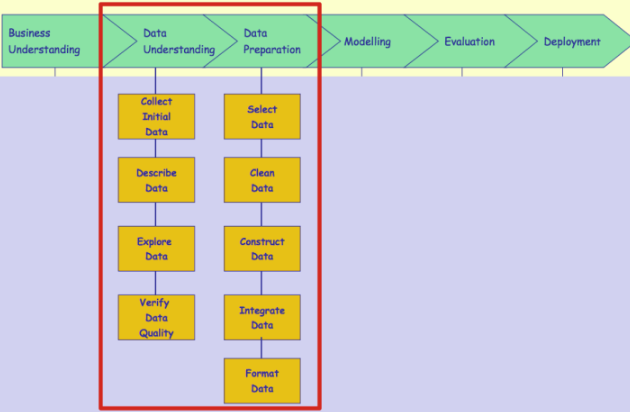

# 0. Bussiness understanding 

In [2]:
current_path =  os.getcwd()
data_dict_path_file =  './data_dict.xlsx'

In [3]:
data_dict_path = os.path.join(current_path, data_dict_path_file)

In [4]:
data_dict_df = pd.read_excel(data_dict_path)



In [5]:
data_dict_df

,VARIABLE,DESCRIPTIONS,Unnamed: 2,Unnamed: 3
0,CUSTOMER_ID,CUSTOMER_ID,NaN,NaN
1,ACT_TYPE,"ACCOUNT TYPE - SAVING, CURRENT OR SALARY ACCOUNT",NaN,** CASA - Current + Savings Account
2,GENDER,GENDER,NaN,*** AMB - Average Monthly Balances
3,LEGAL_ENTITY,TYPE OF COMPANY FOR WHICH ACCOUNT HAS BEEN OPE...,NaN,NaN
4,OCCUP_ALL_NEW,OCCUPATION IS SALARIED FOR ALL THE CUSTOMERS I...,NaN,NaN
...,...,...,...,...
328,CVL_TAG,COMMERCIAL VEHICLE LOAN HOLDING MAPPED FROM AS...,NaN,NaN
329,AL_TAG,AUTO LOAN HOLDING MAPPED FROM ASSET APPLICATIO...,NaN,NaN
330,HL_EMI,MONTHLY HOME LOAN EMI AMOUNT,NaN,NaN
331,SCRUB_EMI,MONTHLY TOTAL EMI PAID TO OTHER BANK FOR THE A...,NaN,NaN


# 1. Data Understanding

## 1.1 Collect Initial Data

In [6]:
current_path =  os.getcwd()
X_train_path_file =  'data/x_train.csv'
X_test_path_file = 'data/x_test.csv'
y_train_path_file = 'data/y_train.csv'

In [7]:
X_train_path = os.path.join(current_path, X_train_path_file)
X_test_pah = os.path.join(current_path, X_test_path_file)
y_train_path = os.path.join(current_path, y_train_path_file)

In [8]:
X_train_df = pd.read_csv(
    filepath_or_buffer= X_train_path,
    sep=','
)
X_test_df = pd.read_csv(
    filepath_or_buffer= X_test_pah,
    sep=','
)
y_train_df = pd.read_csv(
    filepath_or_buffer= y_train_path,
    sep=','
)

In [9]:
print(f'The shape of X train is {X_train_df.shape}')
X_train_df

The shape of X train is (150750, 332)


,CUSTOMER_ID,ACT_TYPE,GENDER,LEGAL_ENTITY,OCCUP_ALL_NEW,AGE,N_CASA_MAX_BALANCE_MTD,N_CASA_MIN_BALANCE_MTD,BL_TAG,TWL_TAG,...,EOP_MON_03,CREDIT_ACT,DEBIT_ACT,CEL_TAG,EL_TAG,AGL_TAG,CVL_TAG,AL_TAG,HL_EMI,SCRUB_EMI
0,211164,CSA,F,INDIVIDUAL,SALARIED,29,213991.68,183483.68,NaN,NaN,...,183352.68,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,256361,CSA,M,INDIVIDUAL,SALARIED,27,32004.10,249.10,NaN,NaN,...,807.60,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,268323,SA,F,INDIVIDUAL,SALARIED,27,13.00,13.00,NaN,NaN,...,13.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,467823,CSA,M,INDIVIDUAL,SALARIED,33,45207.00,31295.00,NaN,NaN,...,17947.00,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,140066,CSA,F,INDIVIDUAL,SALARIED,26,28843.68,3.63,NaN,NaN,...,29106.51,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,2083.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150745,284757,SA,M,INDIVIDUAL,SALARIED,28,10141.46,8642.21,NaN,NaN,...,10441.46,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
150746,437313,SA,M,INDIVIDUAL,SALARIED,32,162.00,159.00,NaN,NaN,...,319.00,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
150747,151386,CSA,M,INDIVIDUAL,SALARIED,28,40011.49,0.00,NaN,Y,...,43341.18,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,2030.679612
150748,293849,CSA,M,INDIVIDUAL,SALARIED,21,7.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1698.857143


In [10]:
print(f'The shape of X test is {X_test_df.shape}')
X_test_df

The shape of X test is (74250, 332)


,CUSTOMER_ID,ACT_TYPE,GENDER,LEGAL_ENTITY,OCCUP_ALL_NEW,AGE,N_CASA_MAX_BALANCE_MTD,N_CASA_MIN_BALANCE_MTD,BL_TAG,TWL_TAG,...,EOP_MON_03,CREDIT_ACT,DEBIT_ACT,CEL_TAG,EL_TAG,AGL_TAG,CVL_TAG,AL_TAG,HL_EMI,SCRUB_EMI
0,272859,SA,M,INDIVIDUAL,SALARIED,38,1033.76,1023.76,NaN,NaN,...,1023.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,186332,CSA,F,INDIVIDUAL,SALARIED,28,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,481412,CSA,F,INDIVIDUAL,SALARIED,22,7545.00,0.00,NaN,NaN,...,0.00,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1814.088398
3,363135,CSA,M,INDIVIDUAL,SALARIED,26,3263.62,41.62,NaN,NaN,...,4247.49,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,431492,CSA,M,INDIVIDUAL,SALARIED,40,2831.45,2516.62,NaN,NaN,...,2311.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,376820,CSA,F,INDIVIDUAL,SALARIED,24,9929.00,3054.00,NaN,NaN,...,9978.00,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
74246,472649,SA,M,INDIVIDUAL,SALARIED,24,6407.25,6318.25,NaN,NaN,...,6318.25,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,2154.082031
74247,194732,CSA,M,INDIVIDUAL,SALARIED,36,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,473.496715
74248,235738,CSA,M,INDIVIDUAL,SALARIED,25,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,982.163265


In [11]:
print(f'The shape of y train is {y_train_df.shape}')
y_train_df

The shape of y train is (150750, 1)


,RESPONDERS
0,0
1,0
2,0
3,0
4,0
...,...
150745,0
150746,0
150747,0
150748,0


## 1.2 Describe Data

In [12]:
def plot_hist_with_perc(data, column_name):
    """
    Plot a histogram with distinct colors for each category and add percentages on the axes and title.

    Parameters:
        data (DataFrame): The input DataFrame containing the data to be plotted.
        column_name (str): The name of the column in the DataFrame to be plotted as a histogram.

    Returns:
        None: This function only displays the plot.

    Raises:
        KeyError: If the specified 'column_name' does not exist in the DataFrame.
        Exception: For unexpected errors during plotting or data processing.

    Example:
        # Suppose you have a DataFrame 'data' with a column 'RESPONDERS':
        import pandas as pd
        data = pd.DataFrame({'RESPONDERS': ['Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No']})

        # Call the function to plot the histogram with percentages:
        plot_hist_with_perc(data, 'RESPONDERS')
    """
    try:
        custom_palette = sns.color_palette("Set2", n_colors=len(data[column_name].unique()))

        sns.set(style='whitegrid', palette=custom_palette)
        ax = plt.axes()

        # Calculate frequencies and percentages for each category
        frequencies = data[column_name].value_counts()
        percentages = (frequencies / len(data)) * 100

        # Plot the histogram with distinct colors for each category
        sns.histplot(data=data, x=column_name, bins=25, discrete=True, palette=custom_palette, ax=ax)

        # Configure labels and title of the plot with percentages
        ax.set(xlabel=column_name, ylabel='Frequency', title=f'Distribution of {column_name} (unit)')
        for p, (cat, freq) in zip(ax.patches, frequencies.items()):
            ax.annotate(f'{freq} ({percentages[cat]:.2f}%)', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')
            
        plt.show()

    except KeyError as e:
        print(f"Error: {e}. Please make sure the column '{column_name}' exists in the dataset.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}. Please check your data and try again.")


In [13]:
def plot_categorical_respect_y(data_df, x_label: str, hue_label: str):
    """
    Plot a categorical histogram with respect to the Y variable (hue_label) in the DataFrame.

    Parameters:
        data_df (pd.DataFrame): The DataFrame containing the data.
        x_label (str): The column name to be used as the x-axis of the plot.
        hue_label (str): The column name to be used as the hue (color) of the plot.

    Raises:
        ValueError: If 'x_label' or 'hue_label' does not exist in the DataFrame.
        TypeError: If 'data_df' is not a valid DataFrame.
    """
    try:
        # Verify if 'data_df' is a valid DataFrame
        if not isinstance(data_df, pd.DataFrame):
            raise TypeError("data_df must be a valid DataFrame object.")

        # Verify if 'x_label' exists in the DataFrame
        if x_label not in data_df.columns:
            raise ValueError(f"The column '{x_label}' does not exist in the DataFrame.")

        # Verify if 'hue_label' exists in the DataFrame
        if hue_label not in data_df.columns:
            raise ValueError(f"The column '{hue_label}' does not exist in the DataFrame.")

        ax = sns.countplot(x=x_label, hue=hue_label, data=data_df)
        plt.title(f'Categorical Histogram of {x_label} with Hue of {hue_label}')
        plt.xlabel(x_label)
        plt.ylabel('Count')

        # calculate percentages and add them as annotations on top of bars
        total_counts = data_df[x_label].count()
        for p in ax.patches:
            height = p.get_height()
            percentage = height / total_counts * 100
            ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, color='black')

        plt.legend(title=hue_label, loc='upper right', labels=['0', '1'])
        plt.show()

    except ValueError as ve:
        print(f"ValueError: {ve}")
    except TypeError as te:
        print(f"TypeError: {te}")

In [14]:
def plot_integer_values_respect_y(data_df, x_label: str, hue_label: str):
    """
    Genera un histograma con valores enteros con respecto a la variable 'x_label' en el DataFrame,
    utilizando la variable 'hue_label' para diferenciar los valores.

    Parameters:
        data_df (pd.DataFrame): El DataFrame que contiene los datos.
        x_label (str): El nombre de la columna para el eje x del gráfico.
        hue_label (str): El nombre de la columna para el color del gráfico.

    Raises:
        ValueError: Si 'x_label' o 'hue_label' no existen en el DataFrame.
        TypeError: Si 'data_df' no es un DataFrame válido.
    """
    try:
        # Verificar si 'data_df' es un DataFrame válido
        if not isinstance(data_df, pd.DataFrame):
            raise TypeError("data_df debe ser un objeto DataFrame válido.")

        # Verificar si 'x_label' existe en el DataFrame
        if x_label not in data_df.columns:
            raise ValueError(f"La columna '{x_label}' no existe en el DataFrame.")

        # Verificar si 'hue_label' existe en el DataFrame
        if hue_label not in data_df.columns:
            raise ValueError(f"La columna '{hue_label}' no existe en el DataFrame.")

        # Aumentar el tamaño del gráfico para tener más espacio para las etiquetas
        plt.figure(figsize=(12, 6))

        # Crear el histograma categórico con respecto a 'x_label' y utilizando 'hue_label'
        ax = sns.countplot(x=x_label, hue=hue_label, data=data_df)

        # Personalizar el título y etiquetas de los ejes
        plt.title(f'Histograma Categórico de {x_label} con Diferenciación de {hue_label}')
        plt.xlabel(x_label)
        plt.ylabel('Conteo')

        # Agregar leyenda para la variable 'hue_label'
        plt.legend(title=hue_label, loc='upper right', labels=['0', '1'])

        # Ajustar el espaciado entre las etiquetas del eje x
        plt.xticks(rotation=45, ha='right')

        plt.show()

    except ValueError as ve:
        print(f"ValueError: {ve}")
    except TypeError as te:
        print(f"TypeError: {te}")

In [15]:
def get_category_values(data_df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Get category values and their frequencies from the given DataFrame.
    Parameters:
        data_df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to be used for grouping.
    Returns:
        pd.DataFrame: A DataFrame containing two columns:
                      - 'COUNT': The frequency of each category.
                      - 'PERCENT': The percentage of each category with respect to the total records.
    Raises:
        ValueError: If 'data_df' is not a valid DataFrame or if the 'column' does not exist in the DataFrame.
    """

    try:
        # Verify if 'data_df' is a valid DataFrame
        if not isinstance(data_df, pd.DataFrame):
            raise ValueError("data_df must be a valid DataFrame object.")

        # Verify if 'column' exists in the DataFrame
        if column not in data_df.columns:
            raise ValueError(f"The column '{column}' does not exist in the DataFrame.")

        data_report = data_df.groupby(column).size()
        total_records = len(data_df)
        percentages = data_report / total_records
        report = pd.DataFrame({
            'COUNT': data_report,
            'PERCENT': percentages
        })
        return report

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [16]:
def get_info(data_df, save_file_name= 'info.xlsx') -> pd.DataFrame:
    """
    Generate a summary of column information from the given DataFrame and save it to an Excel file.
    Parameters:
        data_df (pd.DataFrame): The input DataFrame containing the data.
        save_file_name (str): The name of the Excel file to save the column information.
    Returns:
        pd.DataFrame: A DataFrame containing the summary information of columns.

    Raises:
        ValueError: If data_df is not a pandas DataFrame, or save_file_name is not a string ending with '.xlsx',
                    or the DataFrame is empty.
    Example:
        data = {
            'Column1': [1, 2, None, 4],
            'Column2': [5.0, 6.1, 7.2, None],
            'Column3': ['A', 'B', 'C', 'D']
        }
        df = pd.DataFrame(data)
        save_file_name = "columns_info.xlsx"

        columns_info = get_info(df, save_file_name)
        print("Column information saved in file:", save_file_name)
        print(columns_info)
    """
    try:
        # Verify if the DataFrame is valid
        if not isinstance(data_df, pd.DataFrame):
            raise ValueError("The data_df argument must be a pandas DataFrame.")
        
        # Verify if the file name is valid and has the .xlsx extension
        if not isinstance(save_file_name, str) or not save_file_name.endswith('.xlsx'):
            raise ValueError("The save_file_name argument must be a string ending with '.xlsx'.")
        
        # Verify if the DataFrame is not empty
        if data_df.empty:
            raise ValueError("The DataFrame is empty.")

        # Calculate column information
        no_nulls_por_columns_num = data_df.notnull().sum()
        percent_nulls = 1 - (no_nulls_por_columns_num / len(data_df))
        columns_dtypes = data_df.dtypes 
        columns_info = pd.DataFrame({
            'No_nulls': no_nulls_por_columns_num, 
            'percent_nulls': percent_nulls, 
            'dtype': columns_dtypes
        })
        
        # Save the column information summary to an Excel file
        current_path = os.getcwd()
        path = os.path.join(current_path, save_file_name)
        
        # Verify if the file already exists and remove it if necessary
        if os.path.exists(path):
            os.remove(path)
        
        columns_info.to_excel(path, index=True)
        
        return columns_info
    
    except Exception as e:
        print("Error: ", str(e))
        return None

In [17]:
def get_describe(data_df: pd.DataFrame, save_file_name: str = 'describe.xlsx') -> pd.DataFrame:
    """
    Generate descriptive statistics of a DataFrame and save them to an Excel file.

    Parameters:
        data_df (pd.DataFrame): The input DataFrame for which descriptive statistics will be computed.
        save_file_name (str, optional): The name of the Excel file to save the descriptive statistics.
                                        Default is 'describe.xlsx'.

    Returns:
        pd.DataFrame: A DataFrame containing the descriptive statistics.

    Raises:
        ValueError: If 'data_df' is empty or not a pandas DataFrame.
        Exception: For unexpected errors during computation or saving.

    Example:
        # Suppose you have a DataFrame 'data' with your data:
        import pandas as pd
        data = pd.DataFrame({'Age': [25, 30, 22, 28, 35],
                             'Height': [175, 180, 160, 170, 185],
                             'Weight': [70, 80, 60, 75, 90]})

        # Call the function to get and save the descriptive statistics:
        get_describe(data, 'my_descriptive_stats.xlsx')
    """
    try:
        # Check if the input is a valid DataFrame
        if not isinstance(data_df, pd.DataFrame) or data_df.empty:
            raise ValueError("Input 'data_df' must be a non-empty pandas DataFrame.")

        # Get the current working directory and the path for the Excel file
        current_path = os.getcwd()
        path = os.path.join(current_path, save_file_name)

        # Compute the descriptive statistics
        describe_df = data_df.describe()

        # Save the descriptive statistics to an Excel file
        describe_df.to_excel(path, index=True)

        return describe_df

    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}. Please check your data and try again.")

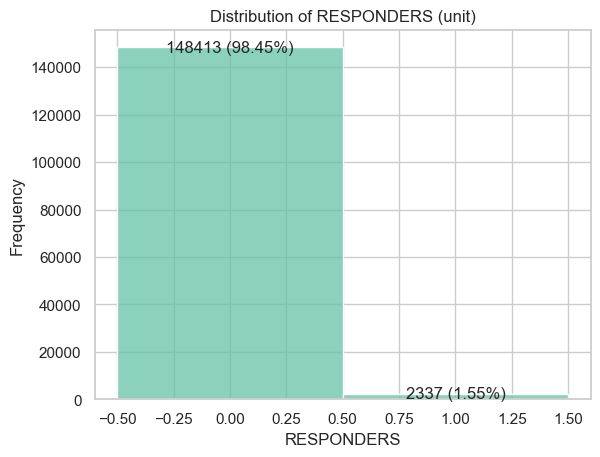

In [18]:
#Observamos los valores que toman nuestra variable de Salida (labels of Targets)
plot_hist_with_perc(data=y_train_df , column_name='RESPONDERS')

In [19]:
get_category_values(data_df=y_train_df , column='RESPONDERS')

,COUNT,PERCENT
RESPONDERS,,
0,148413,0.984498
1,2337,0.015502


In [20]:
# solo el 1 porciento son aceptados

In [21]:
#Observamos los tipo de datos de las columnas del dataframe y el procentaje de missing -> Estas tablas generadas se almacenan en disco 

In [22]:
info_data_df = get_info(data_df=X_train_df, save_file_name= 'x_train_info.xlsx')
info_data_df

,No_nulls,percent_nulls,dtype
CUSTOMER_ID,150750,0.000000,int64
ACT_TYPE,150750,0.000000,object
GENDER,150711,0.000259,object
LEGAL_ENTITY,150750,0.000000,object
OCCUP_ALL_NEW,150750,0.000000,object
...,...,...,...
AGL_TAG,5,0.999967,object
CVL_TAG,4,0.999973,object
AL_TAG,1648,0.989068,object
HL_EMI,866,0.994255,float64


In [23]:
# Nos encotnramos en con un dataframe de alta cantidad de variables categoricas de entradas de 1x332 arrays con alto porcentaje de valores NaN

In [24]:
get_info(data_df=X_test_df, save_file_name= 'x_test_info.xlsx')

,No_nulls,percent_nulls,dtype
CUSTOMER_ID,74250,0.000000,int64
ACT_TYPE,74250,0.000000,object
GENDER,74225,0.000337,object
LEGAL_ENTITY,74250,0.000000,object
OCCUP_ALL_NEW,74250,0.000000,object
...,...,...,...
AGL_TAG,8,0.999892,object
CVL_TAG,2,0.999973,object
AL_TAG,821,0.988943,object
HL_EMI,433,0.994168,float64


In [25]:
#Describimos estadisticamente  las columnas del dataframe -> Estas tablas generadas se almacenan en disco 

In [26]:
get_describe(data_df= X_train_df, save_file_name= 'x_train_describe.xlsx')

,CUSTOMER_ID,AGE,N_CASA_MAX_BALANCE_MTD,N_CASA_MIN_BALANCE_MTD,EEG_TAG,EEG_CLOSED,DC_SPEND_MON_03,DC_SPEND_MON_02,DC_SPEND_MON_01,CC_SPEND_MON_04,...,CC_SPEND_MON_03_JER,CC_SPEND_MON_03_HTL,CC_SPEND_MON_03_ATM,SAL_MON_01,SAL_MON_02,SAL_MON_03,EOP_MON_02,EOP_MON_03,HL_EMI,SCRUB_EMI
count,150750.00000,150750.000000,1.507500e+05,1.507500e+05,0.0,0.0,27068.000000,23723.000000,23902.000000,13080.000000,...,1133.000000,2116.000000,1186.000000,1.036160e+05,1.019030e+05,1.001990e+05,1.502660e+05,1.493680e+05,866.000000,1.507500e+05
mean,249615.61728,34.092325,3.400081e+04,1.035430e+04,NaN,NaN,4175.403279,3700.508261,3754.020108,7589.423729,...,12255.743319,4177.559149,6939.755270,1.598195e+04,1.357969e+04,1.305534e+04,2.154361e+04,2.143821e+04,19117.734411,3.945976e+03
std,144554.52297,14.967699,1.022413e+05,4.731369e+04,NaN,NaN,9267.081822,8515.004494,8352.406647,15725.575144,...,21395.588733,9802.621998,14364.479734,3.620365e+04,3.635322e+04,2.944824e+04,7.044684e+04,6.718403e+04,18035.789592,1.131570e+05
min,10.00000,21.000000,-1.019283e+06,-2.681018e+06,NaN,NaN,0.010000,0.010000,0.000000,1.000000,...,1.110000,0.100000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,-2.511007e+06,-2.511007e+06,74.000000,0.000000e+00
25%,124093.25000,26.000000,7.000000e+00,0.000000e+00,NaN,NaN,587.750000,534.990000,535.000000,1008.750000,...,1800.000000,510.000000,900.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9036.750000,0.000000e+00
50%,249605.50000,31.000000,1.098943e+04,7.100000e+01,NaN,NaN,1606.500000,1422.000000,1432.250000,2946.650000,...,5000.000000,1321.000000,2300.000000,2.740000e+03,0.000000e+00,0.000000e+00,1.384995e+03,1.483950e+03,14485.500000,0.000000e+00
75%,374992.50000,38.000000,3.410161e+04,4.392380e+03,NaN,NaN,4195.157500,3654.445000,3753.750000,7824.237500,...,14078.000000,3886.042500,7000.000000,2.148725e+04,1.846900e+04,1.806250e+04,1.943726e+04,2.018289e+04,23752.000000,2.115753e+02
max,500000.00000,217.000000,1.239114e+07,4.638099e+06,NaN,NaN,301000.000000,263953.750000,235599.000000,382824.100000,...,194280.000000,210000.000000,286864.000000,3.182635e+06,4.226064e+06,2.900000e+06,5.366019e+06,7.500850e+06,186999.000000,3.630903e+07


In [27]:
get_describe(data_df= X_test_df, save_file_name= 'x_test_describe.xlsx')

,CUSTOMER_ID,AGE,N_CASA_MAX_BALANCE_MTD,N_CASA_MIN_BALANCE_MTD,CE_TAG,EEG_TAG,BBG_TAG,EEG_CLOSED,BBG_CLOSED,DC_SPEND_MON_03,...,CC_SPEND_MON_03_HTL,CC_SPEND_MON_03_ATM,SAL_MON_01,SAL_MON_02,SAL_MON_03,EOP_MON_02,EOP_MON_03,CEL_TAG,HL_EMI,SCRUB_EMI
count,74250.000000,74250.000000,7.425000e+04,7.425000e+04,0.0,0.0,0.0,0.0,0.0,13537.000000,...,995.000000,574.000000,5.092000e+04,5.006100e+04,4.924100e+04,7.399800e+04,7.355000e+04,0.0,433.000000,7.425000e+04
mean,249950.987690,34.160714,3.538428e+04,1.048866e+04,NaN,NaN,NaN,NaN,NaN,4166.715762,...,4693.662030,8460.465157,1.629949e+04,1.371400e+04,1.323339e+04,2.139394e+04,2.166454e+04,NaN,19875.073903,3.227273e+03
std,144145.824155,15.029446,3.112670e+05,4.546499e+04,NaN,NaN,NaN,NaN,NaN,9636.239065,...,12389.726633,15404.196333,3.821797e+04,2.993299e+04,2.886992e+04,6.361441e+04,6.338179e+04,NaN,17022.085364,4.076559e+04
min,3.000000,21.000000,-5.529396e+05,-8.848450e+05,NaN,NaN,NaN,NaN,NaN,0.010000,...,2.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,-6.075555e+05,-6.046340e+05,NaN,1022.000000,0.000000e+00
25%,125372.500000,26.000000,8.425000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,575.000000,...,490.000000,1135.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,9606.000000,0.000000e+00
50%,249858.000000,31.000000,1.114215e+04,7.304000e+01,NaN,NaN,NaN,NaN,NaN,1593.470000,...,1330.000000,2687.000000,4.146500e+03,0.000000e+00,0.000000e+00,1.437455e+03,1.560355e+03,NaN,15159.000000,0.000000e+00
75%,374152.500000,39.000000,3.445246e+04,4.467090e+03,NaN,NaN,NaN,NaN,NaN,4210.000000,...,3545.500000,9076.500000,2.176825e+04,1.879000e+04,1.823000e+04,1.960738e+04,2.020698e+04,NaN,25111.000000,2.393575e+02
max,499997.000000,217.000000,8.002659e+07,2.307315e+06,NaN,NaN,NaN,NaN,NaN,298148.000000,...,144954.590000,180498.000000,3.268498e+06,1.267200e+06,1.106286e+06,3.267046e+06,3.268068e+06,NaN,169304.000000,5.878222e+06


## 1.3. Explore Data

## 1.3.1. Forma de los datos

In [28]:
#Shape de la Data
print(f'The shape of X_train_df is: {X_train_df.shape}')
print(f'The shape of X_test_df is: {X_test_df.shape}')

The shape of X_train_df is: (150750, 332)
The shape of X_test_df is: (74250, 332)


In [29]:
#Obtener columnas categoricas:
X_train_category_columns_df = X_train_df.select_dtypes(include=['object', 'category'])
X_test_category_columns_df = X_test_df.select_dtypes(include=['object', 'category'])

In [30]:
print(f'The shape of category X_train_df is: {X_train_category_columns_df.shape}')
print(f'The shape of category X_test_df is: {X_test_category_columns_df.shape}')

The shape of category X_train_df is: (150750, 91)
The shape of category X_test_df is: (74250, 87)


Tenemos 91 columnas categoricas en X_train

Tenemos 87 columnas categoricas en X_test

Hay un diferencia de 4 columnas, observaremos cuales son:

In [31]:
dif_category_set = set(X_train_category_columns_df.columns) - set(X_test_category_columns_df.columns)
dif_category_set

{'BBG_CLOSED', 'BBG_TAG', 'CEL_TAG', 'CE_TAG'}

In [32]:
list(dif_category_set)

['CE_TAG', 'BBG_TAG', 'BBG_CLOSED', 'CEL_TAG']

In [33]:
not_null_rows = X_train_df['BBG_CLOSED'].notnull()
result = X_train_df.loc[not_null_rows, 'BBG_CLOSED']
result.head(10)

118975    Y
Name: BBG_CLOSED, dtype: object

In [34]:
not_null_rows = X_test_df['BBG_CLOSED'].notnull()
result = X_test_df.loc[not_null_rows, 'BBG_CLOSED']
result.head(10)

Series([], Name: BBG_CLOSED, dtype: float64)

In [35]:
# se sabe que esta variable tiene casi 1 % de nulls, no es conveneinte en entrenamiento:
info_data_df.loc['BBG_CLOSED']

No_nulls                1
percent_nulls    0.999993
dtype              object
Name: BBG_CLOSED, dtype: object

In [36]:
#verificamos con  'BBG_TAG'
info_data_df.loc['BBG_TAG']

No_nulls                1
percent_nulls    0.999993
dtype              object
Name: BBG_TAG, dtype: object

In [37]:
info_data_df.loc['CEL_TAG']

No_nulls                1
percent_nulls    0.999993
dtype              object
Name: CEL_TAG, dtype: object

In [38]:
#Eliminamos columnas para evitar problemas de enternamient y consistencia de datos:
X_train_df = X_train_df.drop(list(dif_category_set), axis=1)
X_test_df = X_test_df.drop(list(dif_category_set), axis=1)

In [39]:
#Shape de la Data
print(f'The shape of X_train_df is: {X_train_df.shape}')
print(f'The shape of X_test_df is: {X_test_df.shape}')

The shape of X_train_df is: (150750, 328)
The shape of X_test_df is: (74250, 328)


In [40]:
#Obtener columnasnumericas
X_train_numerical_columns_df = X_train_df.select_dtypes(include=['int64', 'float64'])
X_test_df_numerical_columns_df = X_test_df.select_dtypes(include=['int64', 'float64'])

In [41]:
print(f'The shape of numerical X_train_df is: {X_train_numerical_columns_df.shape}')
print(f'The shape of numerical X_test_df is: {X_test_df_numerical_columns_df.shape}')

The shape of numerical X_train_df is: (150750, 241)
The shape of numerical X_test_df is: (74250, 241)


Tenemos 241 datos numericos:

In [42]:
# Obtener variables con sesgo t:

def get_sekw(data_df: pd.DataFrame, threshold: float):
    # calcular el sesgo de cada variable
    sekw_per_variable_serie = data_df.skew()
    # filtrar las variables con sesgo menor a threshold
    variables_with_sekw_threshold = sekw_per_variable_serie[sekw_per_variable_serie < threshold]
    return variables_with_sekw_threshold


In [43]:
get_sekw(data_df= X_train_numerical_columns_df, threshold= 3.0)

CUSTOMER_ID          0.003967
PM_FD_MON_01         0.000000
COC_ELIGIBLE         2.581186
LAP_SCRUB_LIVE       0.000000
LAS_SCRUB_LIVE       0.000000
PL_SCRUB_LIVE        0.000000
GL_SCRUB_LIVE        0.000000
TWL_SCRUB_LIVE       0.000000
BL_SCRUB_LIVE        0.000000
CEL_SCRUB_LIVE       0.000000
TL_SCRUB_LIVE        0.000000
AL_SCRUB_LIVE        0.000000
LAP_SCRUB_CLOSED     0.000000
LAS_SCRUB_CLOSED     0.000000
PL_SCRUB_CLOSED      0.000000
GL_SCRUB_CLOSED      0.000000
TWL_SCRUB_CLOSED     0.000000
BL_SCRUB_CLOSED      0.000000
CEL_SCRUB_CLOSED     0.000000
TL_SCRUB_CLOSED      0.000000
AL_SCRUB_CLOSED      0.000000
NB_MON_01_CNT        0.000000
NB_MON_02_CNT        0.000000
NB_MON_03_CNT        0.000000
GI_MON_04            1.398695
CC_TXN_MON_01        2.931576
CC_TXN_MON_03        2.573115
CC_TXN_MON_04        2.541289
CC_TXN_MON_05        2.787579
D_COUNT_L3_MON_06    2.277409
D_COUNT_L3_MON_05    2.447642
D_COUNT_L3_MON_04    2.455339
D_COUNT_L3_MON_03    2.508288
D_COUNT_L3

In [44]:
#tenemos columnas numericas con poco sesgo

In [45]:
def get_dense_plot(data_df: pd.DataFrame, column: str):
    """
    Genera un gráfico de densidad (Kernel Density Estimation) para una columna específica en un DataFrame.
    
    Parámetros:
    data_df (pd.DataFrame): El DataFrame que contiene los datos.
    column (str): El nombre de la columna para la cual se generará el gráfico de densidad.

    Excepciones:
    - ValueError: Si la columna no existe en el DataFrame.
    - ValueError: Si la columna no contiene datos numéricos.

    Retorna:
    None
    """
    try:
        # Verificar si la columna existe en el DataFrame
        if column not in data_df.columns:
            raise ValueError(f"La columna '{column}' no existe en el DataFrame.")

        # Verificar si la columna contiene datos numéricos
        if not pd.api.types.is_numeric_dtype(data_df[column]):
            raise ValueError(f"La columna '{column}' no contiene datos numéricos.")

        # Generar el gráfico de densidad
        sns.kdeplot(data=data_df, x=column, fill=True)
        plt.title(f'Densidad de {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Densidad')

        # Indicadores estadísticos al gráfico : mean, median, std_dev
        mean = data_df[column].mean()
        median = data_df[column].median()
        std_dev = data_df[column].std()
        
        plt.axvline(mean, color='red', linestyle='dashed', label=f'Media = {mean:.2f}')
        plt.axvline(median, color='green', linestyle='dashed', label=f'Mediana = {median:.2f}')
        plt.axvline(mean + std_dev, color='purple', linestyle='dashed', label=f'1 Desv. Std. = {mean + std_dev:.2f}')
        plt.axvline(mean - std_dev, color='purple', linestyle='dashed', label=f'1 Desv. Std. = {mean - std_dev:.2f}')
        
        plt.legend()
        plt.show()

    except ValueError as ve:
        print("Error:", ve)

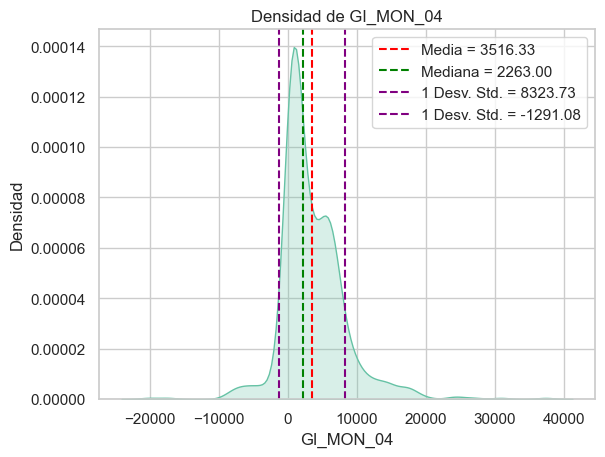

In [46]:
get_dense_plot(data_df=X_train_numerical_columns_df , column= 'GI_MON_04')

In [47]:
def get_qqplot(data_df: pd.DataFrame, column: str):
    """
    Genera un gráfico Q-Q (quantile-quantile) para una columna específica en un DataFrame.
    
    Parámetros:
    data_df (pd.DataFrame): El DataFrame que contiene los datos.
    column (str): El nombre de la columna para la cual se generará el gráfico Q-Q.

    Excepciones:
    - ValueError: Si la columna no existe en el DataFrame.
    - ValueError: Si la columna no contiene datos numéricos.

    Retorna:
    None
    """
    try:
        # Verificar si la columna existe en el DataFrame
        if column not in data_df.columns:
            raise ValueError(f"La columna '{column}' no existe en el DataFrame.")

        # Verificar si la columna contiene datos numéricos
        if not pd.api.types.is_numeric_dtype(data_df[column]):
            raise ValueError(f"La columna '{column}' no contiene datos numéricos.")

        # Generar el gráfico Q-Q
        data_to_plot = data_df[column]
        sm.qqplot(data_to_plot, line='s')
        plt.title(f'Gráfico Q-Q para {column}')
        plt.xlabel('Cuantiles teóricos')
        plt.ylabel(f'Cuantiles de {column}')

        # Agregar indicadores estadísticos al gráfico
        mean = data_to_plot.mean()
        std_dev = data_to_plot.std()

        plt.annotate(f'Media = {mean:.2f}', xy=(sm.ProbPlot(data_to_plot).theoretical_quantiles.mean(), mean),
                     xytext=(15, 50), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
        
        plt.annotate(f'Desv. Std. = {std_dev:.2f}', xy=(sm.ProbPlot(data_to_plot).theoretical_quantiles.std(), std_dev),
                     xytext=(15, 30), textcoords='offset points', arrowprops=dict(arrowstyle='->'))

        plt.show()

    except ValueError as ve:
        print("Error:", ve)


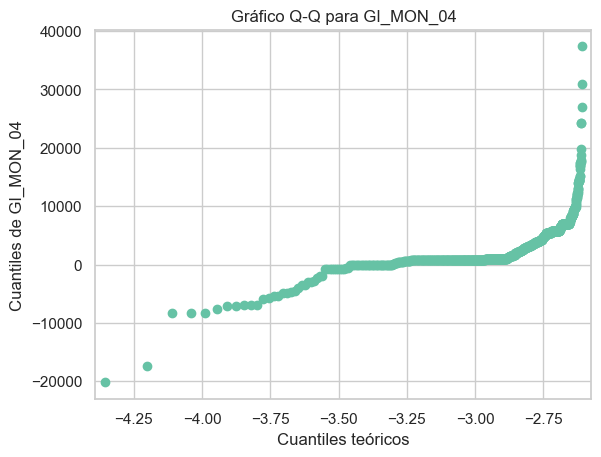

In [48]:
get_qqplot(data_df=X_train_numerical_columns_df , column= 'GI_MON_04')

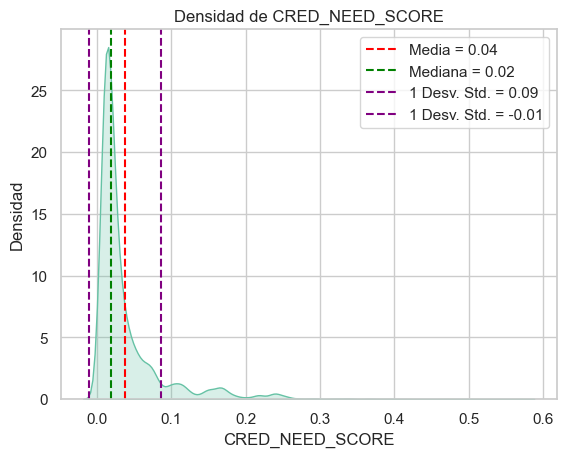

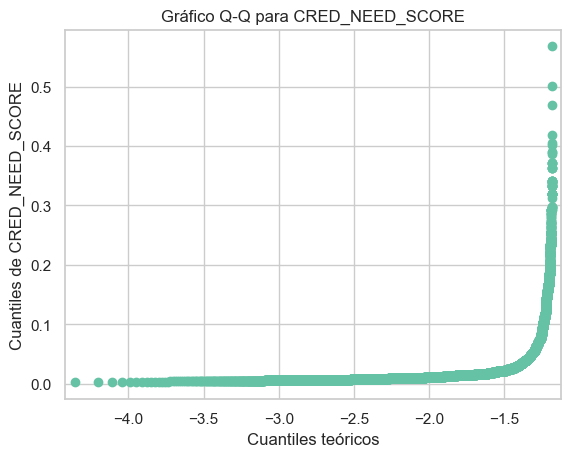

In [49]:
get_dense_plot(data_df=X_train_numerical_columns_df , column= 'CRED_NEED_SCORE')
get_qqplot(data_df=X_train_numerical_columns_df , column= 'CRED_NEED_SCORE')

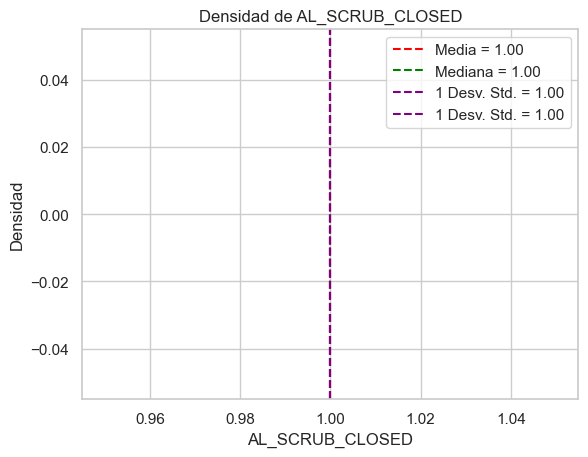

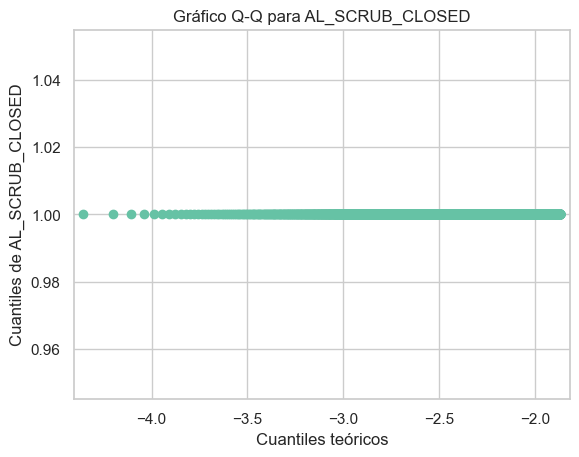

Valores únicos:
###############


array([nan,  1.])

In [50]:
get_dense_plot(data_df=X_train_numerical_columns_df , column= 'AL_SCRUB_CLOSED')
get_qqplot(data_df=X_train_numerical_columns_df , column= 'AL_SCRUB_CLOSED') #son dato binarios
print('Valores únicos:')
print('###############')
X_train_numerical_columns_df['AL_SCRUB_CLOSED'].unique()

Vamos a seleccionar las variables mas importantes para la construcción del modelo, estas son las que se enfocarán en su limpieza.

# 2. Data Preparation

Usaremos Feature Importance para obtener un orden de las variables de acuerdo a su valor representativo.
- Si tenemos 332 variables, entonces escogeremos las 150 más representativas e iremos reduciendo el tamaño de la dimension de entrada con el tiempo.

## 2.1 Theory:


* LightGBM Classifier
    - LightGBM is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms, used for ranking, classification and many other machine learning tasks.
    - LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
        - Faster training speed and higher efficiency.
        - Lower memory usage.
        - Better accuracy.
        - Support of parallel and GPU learning.
        - Capable of handling large-scale data.
    - At present, decision tree based machine learning algorithms dominate Kaggle competitions. The winning solutions in these competitions have adopted an alogorithm called XGBoost.
    - A couple of years ago, Microsoft announced its gradient boosting framework LightGBM. Nowadays, it steals the spotlight in gradient boosting machines. Kagglers start to use LightGBM more than XGBoost. LightGBM is 6 times faster than XGBoost.
    - Light GBM can handle the large size of data and takes lower memory to run.
    - It is not advisable to use LGBM on small datasets. Light GBM is sensitive to overfitting and can easily overfit small data.

* LightGBM grows tree vertically while other tree based learning algorithms grow trees horizontally. It means that LightGBM grows tree leaf-wise while other algorithms grow level-wise. It will choose  the leaf with max delta loss to grow. When growing the same leaf, leaf-wise algorithm can reduce more loss than a level-wise algorithm.

**Leaf-wise tree growth** 

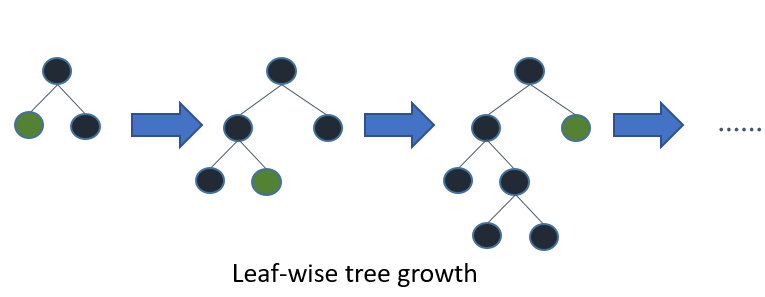

**Level-wise tree growth**

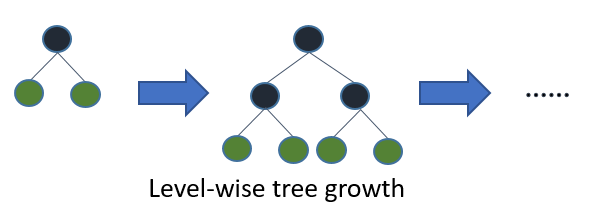

* If we grow the full tree, best-first (leaf-wise) and depth-first (level-wise) will result in the same tree. The difference is in the order in which the tree is expanded. Since we don't normally grow trees to their full depth, order matters.

* Application of early stopping criteria and pruning methods can result in very different trees. Because leaf-wise chooses splits based on their contribution to the global loss and not just the loss along a particular branch, it often (not always) will learn lower-error trees "faster" than level-wise.

* For a small number of nodes, leaf-wise will probably out-perform level-wise. As we add more nodes, without stopping or pruning they will converge to the same performance because they will literally build the same tree eventually.

**Mathematics**

LightGBM es un marco de mejora de gradiente basado en árboles de decisión para aumentar la eficiencia del modelo y reducir el uso de memoria. 
Utiliza dos técnicas novedosas:

* Muestreo de un lado basado en gradiente (GOSS) 
* Paquete de características exclusivas (EFB)

Estas técnicas cumplen con las limitaciones del algoritmo basado en histogramas que se utiliza principalmente en todos los marcos GBDT (Árbol de decisión de aumento de gradiente).

The GOSS (Gradient-based One-Side Sampling) method is used in gradient boosting on a training set with n instances {x1, · · ·, xn}, where each instance xi is a vector with dimension s in space Xs. In each iteration of gradient boosting, the negative gradients of the loss function with respect to the output of the model are represented as {g1, · · ·, gn}. The instances in the training set are ranked in descending order based on their absolute gradient values, and the top-a × 100% instances with the largest gradients are selected to form a subset A.

For the remaining set Ac, consisting of (1- a) × 100% instances with smaller gradients, a random subset B with a size of b × |Ac| is sampled. The instances are then split based on the estimated variance gain at vector Vj (d) over subset A ? B, where

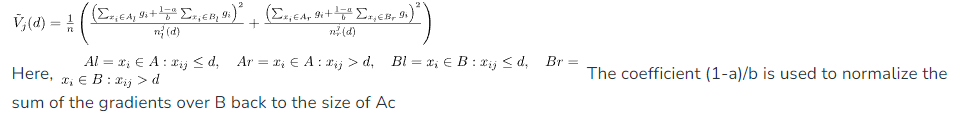

**Gradient-based One Side Sampling Technique for LightGBM**

Diferentes instancias de datos tienen roles variados en el cálculo de la ganancia de información. Las instancias con gradientes más grandes (es decir, instancias poco entrenadas) contribuirán más a la ganancia de información. GOSS mantiene aquellas instancias con gradientes grandes (p. ej., más grandes que un umbral predefinido o entre los percentiles superiores), y solo elimina aleatoriamente aquellas instancias con gradientes pequeños para conservar la precisión de la estimación de la ganancia de información. Este tratamiento puede conducir a una estimación de la ganancia más precisa que el muestreo aleatorio uniforme, con la misma tasa de muestreo objetivo, especialmente cuando el valor de la ganancia de información tiene un amplio rango. 

**Exclusive Feature Bundling Technique for LightGBM**

Los datos de alta dimensión suelen ser muy escasos, lo que nos brinda la posibilidad de diseñar un enfoque casi sin pérdidas para reducir la cantidad de características. Específicamente, en un espacio de características dispersas, muchas características son mutuamente excluyentes, es decir, nunca toman valores distintos de cero simultáneamente. Las funciones exclusivas se pueden agrupar de forma segura en una sola función (llamada paquete de funciones exclusivas). Por lo tanto, la complejidad de la construcción de histogramas cambia de O(datos × característica) a O(datos × paquete) , mientras que paquete<<característica . Por lo tanto, se mejora la velocidad del marco de entrenamiento sin afectar la precisión. 


**Parameters**

* **LightGBM** provides more than 100 LightGBM parameters.

* **max_depth** : It describes the maximum depth of tree. This parameter is used to handle model overfitting. If you feel that your model is overfitted, you should to lower max_depth.

* **min_data_in_leaf** : It is the minimum number of the records a leaf may have. The default value is 20, optimum value. It is also used to deal with overfitting.

* **feature_fraction**: Used when your boosting is random forest. 0.8 feature fraction means LightGBM will select 80% of parameters randomly in each iteration for building trees.

* **bagging_fraction** : specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting.

* **early_stopping_round** : This parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations.* 

* **lambda** $\lambda$: lambda specifies regularization. Typical value ranges from 0 to 1.

* **min_gain_to_split** : This parameter will describe the minimum gain to make a split. It can used to control number of useful splits in tree.

* **max_cat_group** : When the number of category is large, finding the split point on it is easily over-fitting. So LightGBM merges them into ‘max_cat_group’ groups, and finds the split points on the group boundaries, default:64.

**Core parameters**


* **Task** : It specifies the task you want to perform on data. It may be either train or predict.

* **application** : This is the most important parameter and specifies the application of your model, whether it is a regression problem or classification problem. LightGBM will by default consider model as a regression model.

    * **regression** : for regression
    * **binary** : for binary classification
    * **multiclass** : for multiclass classification problem
    * **boosting** : defines the type of algorithm you want to run, default=gdbt.

* **gbdt** : traditional Gradient Boosting Decision Tree
* **rf** : random forest
* **dart** : Dropouts meet Multiple Additive Regression Trees
* **goss** : Gradient-based One-Side Sampling
* **num_boost_round** : Number of boosting iterations, typically 100+

* **learning_rate** : This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…

* **num_leaves** : number of leaves in full tree, default: 31

* **device** : default: cpu, can also pass gpu

* metric: again one of the important parameter as it specifies loss for model building. Below are few general losses for regression and classification.

    * mae : mean absolute error
    * mse : mean squared error
    * binary_logloss : loss for binary classification
    * multi_logloss : loss for multi classification

In [51]:
def feature_importance_series(train: pd.DataFrame, y_train: pd.Series, learner=LGBMClassifier()) -> pd.Series:
    """
    Calculate feature importance using the LGBMClassifier algorithm and return a vector of variables
    sorted by their importance in descending order.

    Parameters:
        train (pd.DataFrame): The input DataFrame containing the training data (features).
        y_train (pd.Series): The target variable (labels) corresponding to the training data.
        learner (LGBMClassifier, optional): An instance of the LGBMClassifier to calculate feature importance.
                                            Default is LGBMClassifier().

    Returns:
        pd.Series: A Series with the feature importances sorted in descending order.

    Example:
        # Suppose you have a DataFrame 'train' with your training data and a Series 'y_train' with labels:
        import pandas as pd
        from lightgbm import LGBMClassifier

        # Create the LGBMClassifier instance
        lgb_model = LGBMClassifier()

        # Call the function to get feature importances
        importances = feature_importance_series(train, y_train, learner=lgb_model)
    """
    # Fit the LGBMClassifier model with the training data and target variable
    learner.fit(train, y_train.loc[train.index])

    # Calculate feature importances and normalize them
    importances = pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=train.columns)

    # Sort the feature importances in descending order
    list_features_imp = importances.sort_values(ascending=False)

    return list_features_imp

In [52]:
def train_get_score_cv(x_train: pd.DataFrame, y_train: pd.Series, models, 
                       pipeline_engine: Pipeline, features_selected: list=None,
                       k=5, random_state=199) -> pd.DataFrame:
    """
    Obtiente el AUC como métrica usando cross validation kfold. El cross validation sirve para simular como 
    el modelo reacciona a datos no observados.
    
    Input:
    x_train[pd.DataFrame]: dataframe que contiene las variables explicativas a entrar en el modelo.
    y_train[pd.Series]: Vector que contiene la variable respuesta.
    models[dict]: Diccionario con los modelos a ser entrenados y evaluados.
    pipeline_engine[Pipeline]: sklearn pipeline --> funciones a ser procesadas en el conjunto de entrenamiento
    k[int]: número de folds en el cross validation
    
    Return:
    Un dataframe con los modelos y el AUC para cada modelo
    """
    if features_selected is None:
        features_selected = x_train.columns
        
    kf = KFold(n_splits=k, shuffle = True, random_state = random_state)
    result = np.zeros((len(models), 1))
    
    for i,model in enumerate(models.keys()):
    
        auc_metric = []
        f1_metric = []

        learner = models[model]
        print(f'Model: {list(models.keys())[i]}')
        for fold, (id_train, id_test) in enumerate(kf.split(x_train, y_train)):

            Xt = x_train.iloc[id_train]; yt = y_train.iloc[id_train]
            Xv = x_train.iloc[id_test]; yv = y_train.iloc[id_test]
            if pipeline_engine != None:
                preprocess_data_cv = pipeline_engine.fit(Xt, yt)
    
                Xt = preprocess_data_cv.transform(Xt)
                Xv = preprocess_data_cv.transform(Xv)
                
            learner.fit(Xt[features_selected], yt.values)
            prediction = pd.Series(learner.predict_proba(Xv[features_selected])[:, -1], index=Xv.index)   
            auc_fold =  metrics.roc_auc_score(yv, prediction)
            auc_metric.append(auc_fold)
            print(f'Fold {fold}: Best auc score: {auc_fold}')
                                 
        auc_opt = np.mean(auc_metric)
        
        result[i] = [auc_opt]
    result = pd.DataFrame(result, columns=["AUC"],index = list(models.keys()))

    return result

## 2.2 Select Data:

Un **pipeline** de datos son funciones, pueden ser entrenadas y guardadas, que sirven para procesar datos semicrudos a datos que un modelo pueda procesar. El pipeline de datos es la mágia por detrás todo buen modelo. Existen muchas formas de transformar las variables para que sean buenas. En la mayoria de los casos un buen pipeline con el modelo correcto genera buenas prediccines y métricas estables.

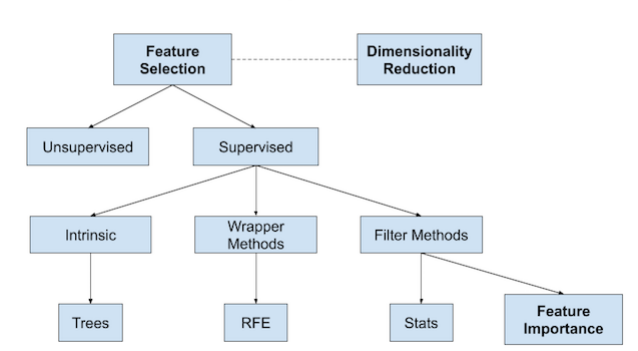

* Vamos a seleccionar las variables mas importantes para la construcción del modelo, estas son las que se enfocarán en su limpieza.

In [53]:
#Obtendremos variables categoricas de nuestro deta set X_train_df
to_drop = ['CUSTOMER_ID']
cat_var = X_train_df.drop(to_drop,axis=1).select_dtypes('O').columns.to_list()

This motivates feature selection, although an alternative to feature selection is to create a
projection of the data into a lower-dimensional space that still preserves the most important
properties of the original data. This is referred to generally as dimensionality reduction and
provides an alternative to feature selection.

The most common approach to dimensionality reduction is to use a matrix
factorization technique:
    
* Principal Component Analysis.
* Singular Value Decomposition.
* Linear Discriminant Analysis.


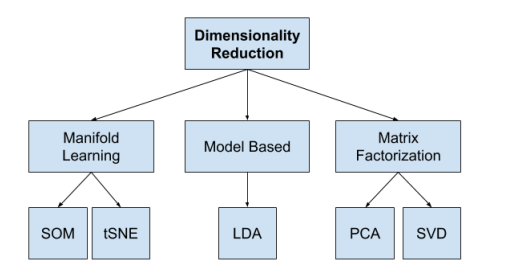

In [54]:
drop_Features = DropFeatures(features_to_drop = to_drop)
categorical_imputer = CategoricalImputer(
    variables=cat_var, 
    fill_value='missing',
    ignore_format = True
)
rare_encoder = RareLabelEncoder(
    tol=0.02, 
    n_categories=2, 
    variables=cat_var,
    replace_with='rare_labels', 
    ignore_format = True
)
mean_encoder = MeanEncoder(
    variables=cat_var, 
    ignore_format = True
)
data_pipeliene = Pipeline([
    ('dropFeatures', drop_Features),
    ('ReplaceNaCat', categorical_imputer),
    ('RareLabelEncoder', rare_encoder),
    ('MeanEncoder', mean_encoder)
])

In [55]:
data_pipeliene

Pipeline(steps=[('dropFeatures',
                 DropFeatures(features_to_drop=['CUSTOMER_ID'])),
                ('ReplaceNaCat',
                 CategoricalImputer(fill_value='missing', ignore_format=True,
                                    variables=['ACT_TYPE', 'GENDER',
                                               'LEGAL_ENTITY', 'OCCUP_ALL_NEW',
                                               'BL_TAG', 'TWL_TAG', 'PL_TAG',
                                               'AL_CNC_TAG', 'AGRI_TAG',
                                               'CV_TAG', 'EDU_TAG', 'TL_TAG',
                                               'OTHER_LOANS_TAG', 'LAP_TAG',
                                               'LAS_TAG', 'HL_TAG', 'GL_TA...
                             variables=['ACT_TYPE', 'GENDER', 'LEGAL_ENTITY',
                                        'OCCUP_ALL_NEW', 'BL_TAG', 'TWL_TAG',
                                        'PL_TAG', 'AL_CNC_TAG', 'AGRI_TAG',
                                        'CV_TAG', 'EDU_TAG', 'TL_TAG',
                                        'OTHER_LOANS_TAG', 'LAP_TAG', 'LAS_TAG',
                                        'HL_TAG', 'GL_TAG', 'AL_CLOSED',
                                        'PL_CLOSED', 'BL_CLOSED', 'TWL_CLOSED',
                                        'CV_CLOSED', 'LAP_CLOSED', 'LAS_CLOSED',
                                        'GL_CLOSED', 'CC_HOLD_MON_03',
                                        'CC_HOLD_MON_02', 'CC_HOLD_MON_01',
                                        'CC_ACTIVE_MON_03', 'CC_ACTIVE_MON_02', ...]))])

In [56]:
#entrenamos la canalización de procesos
X_train_proc = data_pipeliene.fit_transform(X_train_df, y_train_df)

In [57]:
#Calculamos las variables mas importantes con el clasificador LGBMClassifier
list_variables = feature_importance_series(X_train_proc, y_train_df) 

[LightGBM] [Info] Number of positive: 2337, number of negative: 148413
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41121
[LightGBM] [Info] Number of data points in the train set: 150750, number of used features: 308
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015502 -> initscore=-4.151131
[LightGBM] [Info] Start training from score -4.151131


In [58]:
#Escogemos las 150 variables más importantes:
top_150_features = list_variables[:150].index

In [59]:
#Intanciamos el modelo que se entrenará con estas variables seleccionadas:
models = {
    'LGBM': LGBMClassifier(random_state=random_state) 
}

In [60]:
#Entrenamos y obtenemos nuestras primeras métricas:
train_get_score_cv(
    x_train=X_train_df,
    y_train=y_train_df['RESPONDERS'],
    models=models,
    features_selected=top_150_features,
    pipeline_engine=data_pipeliene
)

Model: LGBM
[LightGBM] [Info] Number of positive: 1887, number of negative: 118713
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28555
[LightGBM] [Info] Number of data points in the train set: 120600, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015647 -> initscore=-4.141721
[LightGBM] [Info] Start training from score -4.141721
Fold 0: Best auc score: 0.8779905723905723
[LightGBM] [Info] Number of positive: 1865, number of negative: 118735
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28567
[LightGBM] [Info] Number of data points in the train set: 120600, number of used features: 150
[LightGBM] [Inf

,AUC
LGBM,0.884215


In [61]:
#Con 150 caracteristicas sin limpiar se obtuvo un performance de AUC = 0.884215

In [62]:
print('Top of features: ')
print('#################')
for i, feature in enumerate(top_150_features):
    print(f'{i}-> {feature}')

Top of features: 
#################
0-> DESIGNATION_FINAL
1-> SCRUB_EMI
2-> AGE
3-> C_AMT_L3_MON_05
4-> AMB_MON_04
5-> D_AMT_L3_MON_03
6-> MAX_C_AMT_L3_MON_06
7-> CRED_NEED_SCORE
8-> PA_PQ_TAG
9-> D_AMT_L3_MON_06
10-> D_AMT_L3_MON_04
11-> D_AMT_L3_MON_01
12-> CR_LIMIT
13-> AMB_MON_01
14-> SAL_MON_02
15-> PL_TAG
16-> STMT_MON_01
17-> MAX_C_AMT_L3_MON_01
18-> D_AMT_L3_MON_05
19-> C_AMT_L3_MON_06
20-> DC_SPEND_MON_06
21-> EOP_MON_02
22-> CC_SPEND_MON_06
23-> MAX_C_AMT_L3_MON_04
24-> D_AMT_L3_MON_02
25-> MAX_C_AMT_L3_MON_05
26-> D_COUNT_L3_MON_06
27-> SAL_MON_01
28-> MAX_C_AMT_L3_MON_02
29-> AMB_MON_03
30-> EOP_BAL_MON_01
31-> AMB_MON_02
32-> D_COUNT_L3_MON_01
33-> IMPS_CC_AMOUNT_MON_01
34-> EOP_MON_03
35-> D_COUNT_L3_MON_03
36-> NEFT_CC_AMOUNT
37-> SAL_MON_03
38-> CC_SPEND_MON_05
39-> DC_TXN_MON_04
40-> C_AMT_L3_MON_04
41-> DC_SPEND_MON_04
42-> STMT_MON_03
43-> N_CASA_MIN_BALANCE_MTD
44-> C_AMT_L3_MON_03
45-> C_AMT_L3_MON_01
46-> DC_TXN_MON_03
47-> CC_SPEND_MON_04
48-> NEFT_DC_AMOUNT
49->

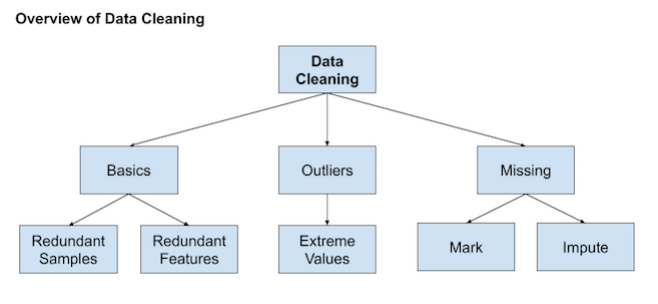

## 2.3 Data Cleaning:

Separamos datos numericos de categoricos:

In [132]:
top_150_features

Index(['DESIGNATION_FINAL', 'SCRUB_EMI', 'AGE', 'C_AMT_L3_MON_05',
       'AMB_MON_04', 'D_AMT_L3_MON_03', 'MAX_C_AMT_L3_MON_06',
       'CRED_NEED_SCORE', 'PA_PQ_TAG', 'D_AMT_L3_MON_06',
       ...
       'CC_SPEND_MON_01_ENT', 'TOP14_CITY', 'NEFT_CC_TXN',
       'DC_SPEND_MON_03_JER', 'CC_SPEND_MON_03_ENT', 'CC_SPEND_MON_02_JER',
       'CC_SPEND_MON_03_MED', 'FD_MON_04', 'HL_EMI', 'CC_SPEND_MON_03_HMD'],
      dtype='object', length=150)

In [133]:
X_selected_train_df = X_train_df[top_150_features]
X_selected_test_df = X_test_df[top_150_features]

In [134]:
#Shape de la Data
print(f'The shape of X_selected_train_df is: {X_selected_train_df.shape}')
print(f'The shape of X_selected_test_df is: {X_selected_test_df.shape}')

The shape of X_selected_train_df is: (150750, 150)
The shape of X_selected_test_df is: (74250, 150)


### 2.3 Redundant Samples 

In [67]:
#Obtener columnas categoricas:
X_selected_train_category_columns_df = X_selected_train_df.select_dtypes(include=['object', 'category'])
X_selected_test_category_columns_df = X_selected_test_df.select_dtypes(include=['object', 'category'])

In [73]:
print(f'The shape of category X_train_df is: {X_selected_train_category_columns_df.shape}')
print(f'The shape of category X_test_df is: {X_selected_test_category_columns_df.shape}')

The shape of category X_train_df is: (150750, 12)
The shape of category X_test_df is: (74250, 12)


In [70]:
#Obtener columnasnumericas
X_selected_train_numerical_columns_df = X_selected_train_df.select_dtypes(include=['int64', 'float64'])
X_selected_test_numerical_columns_df = X_selected_test_df.select_dtypes(include=['int64', 'float64'])

In [75]:
#Tenemos una gran variedad de datos numericos

In [71]:
print(f'The shape of numerical X_train_df is: {X_selected_train_numerical_columns_df.shape}')
print(f'The shape of numerical X_test_df is: {X_selected_test_df_numerical_columns_df.shape}')

The shape of numerical X_train_df is: (150750, 138)
The shape of numerical X_test_df is: (74250, 138)


### 2.3.1 Identify Columns That Contain a Single Value and  Consider Columns That Have Very Few Values

When a predictor contains a single value, we call this a zero-variance predictor because there truly is no variation displayed by the predictor.

Columns that have a single value for all rows do not contain any information for modeling. Depending on the choice of data preparation and modeling algorithms, variables with a single value can also cause errors or unexpected results. 

In [74]:
# Para variables categoricas:

In [78]:
unique_category_values_with_nan = X_selected_train_category_columns_df.nunique(dropna=False)

In [79]:
unique_category_values_with_nan

DESIGNATION_FINAL      11
PA_PQ_TAG             123
PL_TAG                  2
FINANCE_MON_01          2
GENDER                  3
CHANNEL_CLICK_DISP      3
LAST_3MTHS_INQ          2
PL_CLOSED               2
TWL_TAG                 2
CC_HOLD_MON_01          2
AL_TAG                  2
TOP14_CITY              2
dtype: int64

In [119]:
print('Unique values:')
for variable in X_selected_train_category_columns_df:
    print(f'{variable} : {X_selected_train_category_columns_df[variable].unique()}')

Unique values:
DESIGNATION_FINAL : ['MISSING' 'EXECUTIVE' 'MANAGER' 'ENGINEER' 'OTHERS' 'OFFICER'
 'SUP/TECH/OPR' 'REMAING' 'DEVEP/PROG/ANALYST/ASSO' 'TOP_MANAG/DOC'
 'TEACH/PROF/CONSULT']
PA_PQ_TAG : ['STP' nan 'Green Channel' 'PQ with Ref dedupe' 'PQ_WITH_INCOME_15K'
 'PQ with Coapp' 'PQ_WITH_INCOME_34K' 'PQ_WITH_INCOME_35K'
 'PQ with Dedupe' 'PQ_WITH_INCOME_25K' 'PQ_WITH_INCOME_22K'
 'PQ with Neg dedupe' 'PQ with Account' 'PQ_WITH_INCOME_18K'
 'PQ_WITH_INCOME_27K' 'PQ_WITH_INCOME_16K' 'PQ_WITH_INCOME_29K'
 'PQ with KYC' 'PQ_WITH_INCOME_46K' 'PQ_WITH_INCOME_66K'
 'PQ_WITH_INCOME_33K' 'PQ_WITH_INCOME_37K' 'PQ_WITH_INCOME_20K'
 'PQ_WITH_INCOME_100K' 'PQ_WITH_INCOME_42K' 'PQ_WITH_INCOME_38K'
 'PQ_WITH_INCOME_31K' 'PQ_WITH_INCOME_68K' 'PQ_WITH_INCOME_125K'
 'PQ_WITH_INCOME_23K' 'PQ_WITH_INCOME_21K' 'PQ_WITH_INCOME_30K'
 'PQ_WITH_INCOME_17K' 'PQ_WITH_INCOME_26K' 'PQ_WITH_INCOME_24K'
 'PQ_WITH_INCOME_32K' 'PQ_WITH_INCOME_86K' 'PQ_WITH_INCOME_59K'
 'PQ_WITH_INCOME_40K' 'PQ_WITH_INCOME_83K' 

In [100]:
############################################################ GENDER ########################################################

In [101]:
get_category_values(data_df=X_selected_train_category_columns_df , column= 'GENDER')

,COUNT,PERCENT
GENDER,,
F,35013,0.232259
M,115698,0.767483


In [103]:
X_selected_train_category_columns_df['GENDER'].unique() #DEBEMOS ELIMNAR VALORES NaN 

array(['F', 'M', nan], dtype=object)

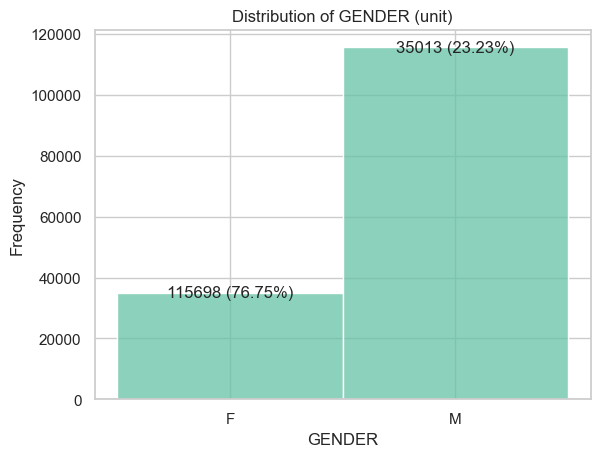

In [104]:
plot_hist_with_perc(data=X_selected_train_category_columns_df, column_name='GENDER')

In [106]:
X_selected_train_df[X_selected_train_df['GENDER'].isna()] #DEBEMOS ELIMNAR VALORES NaN puesto que son un valor BAJO

,DESIGNATION_FINAL,SCRUB_EMI,AGE,C_AMT_L3_MON_05,AMB_MON_04,D_AMT_L3_MON_03,MAX_C_AMT_L3_MON_06,CRED_NEED_SCORE,PA_PQ_TAG,D_AMT_L3_MON_06,...,CC_SPEND_MON_01_ENT,TOP14_CITY,NEFT_CC_TXN,DC_SPEND_MON_03_JER,CC_SPEND_MON_03_ENT,CC_SPEND_MON_02_JER,CC_SPEND_MON_03_MED,FD_MON_04,HL_EMI,CC_SPEND_MON_03_HMD
1913,MISSING,1465.954521,25,NaN,0.00,NaN,NaN,NaN,NaN,NaN,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2066,MISSING,0.000000,217,NaN,56043.05,NaN,NaN,NaN,NaN,NaN,...,NaN,Y,2.0,NaN,NaN,NaN,NaN,216421.08,NaN,NaN
3034,MISSING,11731.613920,28,NaN,1421.54,34752.64,2000.0,NaN,NaN,4267.00,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5789,MISSING,0.000000,28,19397.00,5050.25,14165.59,14490.0,NaN,NaN,14545.59,...,NaN,N,3.0,1500.0,NaN,NaN,NaN,NaN,NaN,NaN
14939,MISSING,0.000000,22,NaN,0.00,NaN,NaN,NaN,NaN,NaN,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16773,MISSING,0.000000,38,NaN,0.00,NaN,NaN,NaN,NaN,841.11,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19762,MISSING,7689.240107,42,NaN,645.23,2.00,NaN,NaN,NaN,NaN,...,NaN,N,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21041,MISSING,0.000000,22,119.38,837.05,6023.01,9332.0,NaN,NaN,12725.64,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23910,MISSING,0.000000,26,NaN,18.10,215.74,NaN,NaN,NaN,NaN,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31717,MISSING,5798.831776,30,NaN,0.00,NaN,NaN,NaN,NaN,NaN,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
X_selected_train_df_sin_nulos = X_selected_train_df.dropna(subset=['GENDER'])

In [ ]:
############################################################################################################################

In [ ]:
############################################################ DESIGNATION_FINAL ########################################################

In [110]:
descripcion = data_dict_df[data_dict_df['VARIABLE'] == 'DESIGNATION_FINAL']['DESCRIPTIONS'].iloc[0]
# Convertir la descripción a string
descripcion

'CUSTOMER DESIGNATION IN COMPANY WHERE HE WORKS'

In [111]:
info_data_df.loc['DESIGNATION_FINAL'] #tenemos 0 nulls

No_nulls         150750
percent_nulls       0.0
dtype            object
Name: DESIGNATION_FINAL, dtype: object

In [108]:
get_category_values(data_df=X_selected_train_category_columns_df , column= 'DESIGNATION_FINAL')

,COUNT,PERCENT
DESIGNATION_FINAL,,
DEVEP/PROG/ANALYST/ASSO,3279,0.021751
ENGINEER,4057,0.026912
EXECUTIVE,5590,0.037081
MANAGER,4757,0.031556
MISSING,117311,0.778182
OFFICER,3637,0.024126
OTHERS,5026,0.033340
REMAING,3204,0.021254
SUP/TECH/OPR,2075,0.013765


In [ ]:
#######################################################################################################################################

In [92]:
descripcion_pa_pq_tag = data_dict_df[data_dict_df['VARIABLE'] == 'PA_PQ_TAG']['DESCRIPTIONS'].iloc[0]
# Convertir la descripción a string
descripcion_pa_pq_tag

'PRE-APPROVED OR PRE-QUALIFIED STATUS - CUSTOMER IS PRE-APPROVED FOR THE PERSONAL LOAN- THIS IS INTERNALLY DECIDED BY THE BANK'

In [98]:
top_150_features

Index(['DESIGNATION_FINAL', 'SCRUB_EMI', 'AGE', 'C_AMT_L3_MON_05',
       'AMB_MON_04', 'D_AMT_L3_MON_03', 'MAX_C_AMT_L3_MON_06',
       'CRED_NEED_SCORE', 'PA_PQ_TAG', 'D_AMT_L3_MON_06',
       ...
       'CC_SPEND_MON_01_ENT', 'TOP14_CITY', 'NEFT_CC_TXN',
       'DC_SPEND_MON_03_JER', 'CC_SPEND_MON_03_ENT', 'CC_SPEND_MON_02_JER',
       'CC_SPEND_MON_03_MED', 'FD_MON_04', 'HL_EMI', 'CC_SPEND_MON_03_HMD'],
      dtype='object', length=150)

In [99]:
indice_pa_pq_tag = top_150_features.get_loc('PA_PQ_TAG')
print("El índice de 'PA_PQ_TAG' es:", indice_pa_pq_tag) 

El índice de 'PA_PQ_TAG' es: 8


In [ ]:
# Es una variable importante por su posicion de importancia

In [93]:
get_category_values(data_df= X_selected_train_category_columns_df, column='PA_PQ_TAG')

,COUNT,PERCENT
PA_PQ_TAG,,
Green Channel,31663,0.210036
PQ with Account,275,0.001824
PQ with Coapp,89,0.000590
PQ with Dedupe,404,0.002680
PQ with KYC,172,0.001141
...,...,...
PQ_WITH_INCOME_96K,3,0.000020
PQ_WITH_INCOME_97K,2,0.000013
PQ_WITH_INCOME_98K,2,0.000013


In [95]:
#aplicaremos una codificación incluyendo NaN

In [94]:
info_data_df.loc['PA_PQ_TAG']

No_nulls           64937
percent_nulls    0.56924
dtype             object
Name: PA_PQ_TAG, dtype: object

In [138]:

class ZeroImputer(BaseEstimator, TransformerMixin):
    """
    Transformador personalizado que reemplaza valores faltantes por 0 en columnas específicas o en todo el DataFrame.

    Parámetros
    ----------
    columns : list, opcional
        Lista de nombres de columnas en las que se aplicará la imputación de ceros. Si no se proporciona,
        se aplicará a todas las columnas del DataFrame.

    Ejemplo
    -------
    # Crear un DataFrame de ejemplo con valores faltantes
    data = {'col1': [1, 2, None, 4],
            'col2': [5, None, None, 8]}
    df = pd.DataFrame(data)

    # Instanciar la clase ZeroImputer para imputar ceros en 'col1'
    imputer = ZeroImputer(columns=['col1'])

    # Aplicar la imputación al DataFrame de ejemplo
    df_imputed = imputer.transform(df)

    print("DataFrame original:")
    print(df)
    print("\nDataFrame con imputación de ceros:")
    print(df_imputed)
    """
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        # La imputación no requiere ajuste, por lo que no hacemos nada aquí.
        return self

    def transform(self, X):
        """
        Transforma el DataFrame reemplazando valores faltantes por 0 en columnas específicas o en todo el DataFrame.

        Parámetros
        ----------
        X : pandas.DataFrame
            DataFrame a transformar.

        Devuelve
        --------
        X_imputed : pandas.DataFrame
            DataFrame transformado con los valores faltantes reemplazados por 0 en las columnas especificadas o en todo el DataFrame.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un DataFrame.")
        
        X_imputed = X.copy()
        
        if self.columns:
            for column in self.columns:
                if column not in X_imputed.columns:
                    raise ValueError(f"La columna '{column}' no se encuentra en el DataFrame.")
                X_imputed[column].fillna(0, inplace=True)
        else:
            X_imputed.fillna(0, inplace=True)
            
        return X_imputed
    

class DropDuplicateRows(BaseEstimator, TransformerMixin):
    """
    Transformador personalizado que elimina filas duplicadas de un DataFrame.
    
    Ejemplo
    -------
    # Crear un DataFrame de ejemplo con filas duplicadas
    data = {'col1': [1, 2, 2, 3],
            'col2': ['A', 'B', 'B', 'C']}
    df = pd.DataFrame(data)

    # Instanciar la clase DropDuplicateRows
    deduplicator = DropDuplicateRows()

    # Aplicar la transformación al DataFrame de ejemplo
    df_deduplicated = deduplicator.transform(df)

    print("DataFrame original:")
    print(df)
    print("\nDataFrame con filas duplicadas eliminadas:")
    print(df_deduplicated)
    """
    def fit(self, X, y=None):
        # La eliminación de filas duplicadas no requiere ajuste, por lo que no hacemos nada aquí.
        return self
    
    def transform(self, X):
        """
        Transforma el DataFrame eliminando filas duplicadas.

        Parámetros
        ----------
        X : pandas.DataFrame
            DataFrame a transformar.

        Devuelve
        --------
        X_deduplicated : pandas.DataFrame
            DataFrame transformado con las filas duplicadas eliminadas.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un DataFrame.")
        
        X_deduplicated = X.drop_duplicates()
        return X_deduplicated
    
class CutoffTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador personalizado que reemplaza valores mayores que un valor de corte por la mediana de la columna.

    Parámetros
    ----------
    cutoff_value : float
        Valor de corte. Los valores en las columnas mayores que este valor serán reemplazados por la mediana.
    variables : list
        Lista de nombres de columnas en las que se aplicará la transformación.

    Ejemplo
    -------
    # Crear un DataFrame de ejemplo
    data = {'col1': [10, 15, 20, 25],
            'col2': [5, 12, 18, 30]}
    df = pd.DataFrame(data)

    # Instanciar la clase CutoffTransformer con un valor de corte de 20 en 'col1'
    transformer = CutoffTransformer(cutoff_value=20, variables=['col1'])

    # Aplicar la transformación al DataFrame de ejemplo
    df_transformed = transformer.transform(df)

    print("DataFrame original:")
    print(df)
    print("\nDataFrame transformado:")
    print(df_transformed)
    """
    def __init__(self, cutoff_value, variables):
        self.cutoff_value = cutoff_value
        self.variables = variables
    
    def fit(self, X, y=None):
        # La transformación no requiere ajuste, por lo que no hacemos nada aquí.
        return self
    
    def transform(self, X):
        """
        Transforma el DataFrame reemplazando valores mayores que un valor de corte por la mediana de la columna.

        Parámetros
        ----------
        X : pandas.DataFrame
            DataFrame a transformar.

        Devuelve
        --------
        X_transformed : pandas.DataFrame
            DataFrame transformado con los valores mayores que el valor de corte reemplazados por la mediana.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un DataFrame.")
        
        X_transformed = X.copy()
        
        for variable in self.variables:
            if variable not in X_transformed.columns:
                raise ValueError(f"La variable '{variable}' no se encuentra en el DataFrame.")
            
            median = X_transformed[variable].median()
            X_transformed[variable] = np.where(X_transformed[variable] > self.cutoff_value, median, X_transformed[variable])
            
        return X_transformed
    
    
    
   
class NanThresholdEncoder(BaseEstimator, TransformerMixin):
    """
    Transformador personalizado que reemplaza valores NaN por 0 y valores no NaN por 1 en columnas específicas.
    
    Parámetros
    ----------
    columns : list, opcional
        Lista de nombres de columnas en las que se aplicará la transformación. Si no se proporciona, se aplicará
        a todas las columnas del DataFrame.
    """
    def __init__(self, columns=None):
        if columns is None:
            raise ValueError("Debe proporcionar una lista de columnas para la transformación.")
        self.columns = columns
    
    def transform(self, X):
        """
        Transforma el DataFrame reemplazando valores NaN por 0 y valores no NaN por 1 en las columnas especificadas.
        
        Parámetros
        ----------
        X : pandas.DataFrame
            DataFrame a transformar.
            
        Devuelve
        --------
        X_transformed : pandas.DataFrame
            DataFrame transformado con los valores NaN reemplazados por 0 y valores no NaN por 1 en las columnas
            especificadas.
            
        Ejemplo
        -------
        # Crear un DataFrame de ejemplo
        data = {'col1': [1, np.nan, 3, 4],
                'col2': ['A', 'B', np.nan, 'C']}
        df = pd.DataFrame(data)

        # Instanciar la clase NanThresholdEncoder
        encoder = NanThresholdEncoder(columns=['col1', 'col2'])

        # Aplicar la transformación al DataFrame de ejemplo
        df_transformed = encoder.transform(df)

        print("DataFrame original:")
        print(df)
        print("\nDataFrame transformado:")
        print(df_transformed)
            """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un DataFrame.")
        
        X_transformed = X.copy()
        for column in self.columns:
            X_transformed[column] = np.where(X[column].notna(), 1, 0)
        return X_transformed

In [145]:

X_selected_train_df['AGE']

0         29
1         27
2         27
3         33
4         26
          ..
150745    28
150746    32
150747    28
150748    21
150749    33
Name: AGE, Length: 150750, dtype: int64

In [150]:
#PEPILINE



CutoffTransformer_pipe = CutoffTransformer(cutoff_value=20, variables=['AGE'])

pipeline = Pipeline([
                    ('CutoffTransformer',CutoffTransformer_pipe),                                
                    ])


In [151]:
pipeline

Pipeline(steps=[('CutoffTransformer',
                 CutoffTransformer(cutoff_value=20, variables=['AGE']))])

In [152]:
X_train_p = pipeline.fit_transform(X_selected_train_df, y_train_df)

In [153]:
X_train_p

,DESIGNATION_FINAL,SCRUB_EMI,AGE,C_AMT_L3_MON_05,AMB_MON_04,D_AMT_L3_MON_03,MAX_C_AMT_L3_MON_06,CRED_NEED_SCORE,PA_PQ_TAG,D_AMT_L3_MON_06,...,CC_SPEND_MON_01_ENT,TOP14_CITY,NEFT_CC_TXN,DC_SPEND_MON_03_JER,CC_SPEND_MON_03_ENT,CC_SPEND_MON_02_JER,CC_SPEND_MON_03_MED,FD_MON_04,HL_EMI,CC_SPEND_MON_03_HMD
0,MISSING,0.000000,31.0,264804.0,187873.12,23807.00,29950.0,NaN,STP,28936.55,...,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EXECUTIVE,0.000000,31.0,60002.0,60636.86,85755.00,27678.0,0.055877,NaN,26755.00,...,1510.0,N,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MISSING,0.000000,31.0,NaN,13.00,NaN,NaN,NaN,NaN,NaN,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MISSING,0.000000,31.0,NaN,5645.77,NaN,NaN,NaN,Green Channel,NaN,...,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MISSING,2083.333333,31.0,37300.0,18888.74,33501.75,27500.0,NaN,STP,46045.75,...,NaN,Y,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150745,MISSING,0.000000,31.0,44913.0,12294.21,3678.55,NaN,NaN,NaN,5993.78,...,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150746,MISSING,0.000000,31.0,7550.0,629.65,8000.00,7550.0,NaN,NaN,7500.00,...,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150747,OTHERS,2030.679612,31.0,547255.0,10363.79,387797.89,380000.0,NaN,NaN,490537.86,...,NaN,Y,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150748,MISSING,1698.857143,31.0,NaN,12121.12,8234.77,NaN,NaN,NaN,6.00,...,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
